<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/RAG_using_LlamaIndex_Workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required Dependencies

In [77]:
%pip install -qU llama-index llama-index-llms-groq llama-index-readers-web pyvis

In [75]:
import llama_index

print(llama_index.core.__version__)


0.11.8


In [134]:
!python


Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> exit()


In [78]:
%pip install -qU llama-index-embeddings-huggingface
%pip install -qU llama-index-embeddings-instructor

## Set up Groq API

In [79]:
from google.colab import userdata
import os
#
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [124]:
os.environ["GROQ_API_KEY"]

'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'

## Setup Embedding Model

In [80]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# loads BAAI/bge-small-en-v1.5
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

## setup llm

In [5]:
from llama_index.llms.groq import Groq
llm = Groq(model="llama3-70b-8192")
llm.complete("What is the capital of France?")

CompletionResponse(text='The capital of France is Paris!', additional_kwargs={}, raw=ChatCompletion(id='chatcmpl-5a23db00-a4dc-4d04-baf0-59d55db7ee1d', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The capital of France is Paris!', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1725935013, model='llama3-70b-8192', object='chat.completion', service_tier=None, system_fingerprint='fp_c1a4bcec29', usage=CompletionUsage(completion_tokens=8, prompt_tokens=17, total_tokens=25, queue_time=0.013888734000000002, prompt_time=0.000441246, completion_time=0.025723569, total_time=0.026164815), x_groq={'id': 'req_01j7cvwm28edhscnwg6vbyg9b2'}), logprobs=None, delta=None)

## Import Required Dependencies

In [6]:
from llama_index.core.workflow import (Event,StartEvent,StopEvent,Workflow,step,Context)
from llama_index.core import VectorStoreIndex
from llama_index.core.schema import NodeWithScore
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.readers.web import SimpleWebPageReader
from llama_index.core import SimpleDirectoryReader

## Download Data

In [7]:
mkdir Data

In [8]:
!wget https://www.binasss.sa.cr/int23/8.pdf -O Data/fibromyalgia.pdf

--2024-09-10 02:23:34--  https://www.binasss.sa.cr/int23/8.pdf
Resolving www.binasss.sa.cr (www.binasss.sa.cr)... 196.40.24.242
Connecting to www.binasss.sa.cr (www.binasss.sa.cr)|196.40.24.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632664 (618K) [application/pdf]
Saving to: ‘Data/fibromyalgia.pdf’

Data/fibromyalgia.p 100%[===================>] 617.84K  1.91MB/s    in 0.3s    

2024-09-10 02:23:35 (1.91 MB/s) - ‘Data/fibromyalgia.pdf’ saved [632664/632664]



## Create Retriever Event

In [81]:
class RetrieverEvent(Event):
  nodes: list[NodeWithScore]

In [82]:
class IndexEvent(Event):
  index: VectorStoreIndex

## Construct Workflow and Step

In [21]:
class RAGWorkflow(Workflow):
  @step()
  async def ingest(self,ctx:Context,ev:StartEvent)->StopEvent | None:
    print("Ingesting documents...")
    "Entry point to ingest a documents trigerred by a StartEvent with `dirname`"
    dirname = ev.get("dirname")
    if not dirname:
      return None
    # loads BAAI/bge-small-en-v1.5
    embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
    documents = SimpleDirectoryReader(input_dir="Data/").load_data()
    index = VectorStoreIndex.from_documents(documents=documents,
                                            embed_model=embed_model)
    print(f"Indexed {len(documents)} documents.")

    return StopEvent(result=index)

In [22]:
w = RAGWorkflow(timeout=10, verbose=False)
result = await w.run(dirname="Data")
print(result)

Ingesting documents...
Indexed 8 documents.


In [ ]:
%pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:0

In [ ]:
%pip install llama-index-vector-stores-chroma

In [ ]:
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import chromadb
# create client and a new collection
chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("RAGworkflow")

UniqueConstraintError: Collection workflow already exists

In [ ]:

from IPython.display import Markdown, display
# define embedding function
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

# load documents
documents = SimpleDirectoryReader("./Data/").load_data()

# set up ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context, embed_model=embed_model
)

# Query Data
query_engine = index.as_query_engine(llm=llm)
response = query_engine.query("What is Fibromyalgia?")
display(Markdown(f"{response}"))

The diagnosis of fibromyalgia is established to reassure patients and prevent further unnecessary testing and anxiety.

In [ ]:
class RAGWorkflow(Workflow):
    @step(pass_context=True)
    async def ingest(self, ctx: Context, ev: StartEvent) -> StopEvent | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        print(f"directory name: {dirname}")
        if not dirname:
            return None
        dname  = f"./{dirname}/"
        #
        db = chromadb.PersistentClient(path="./chroma_db")
        chroma_collection = db.get_or_create_collection("wflows")
        vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
        storage_context = StorageContext.from_defaults(vector_store=vector_store)
        # define embedding function
        embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")
        #
        documents = SimpleDirectoryReader(input_dir=dname).load_data()
        # set up ChromaVectorStore and load in data
        vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
        storage_context = StorageContext.from_defaults(vector_store=vector_store)
        ctx.data["index"] = VectorStoreIndex.from_documents(
            documents=documents,
            storage_context=storage_context,
            embed_model=embed_model,
        )
        print(f"Indexed {len(documents)} documents.")
        return StopEvent(result=f"Indexed {len(documents)} documents.")

    @step(pass_context=True)
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> RetrieverEvent | None:
        "RAG Entry, triggered by a StartEvent with `query`."
        query = ev.get("query")
        print(f"Query the database with: {query}")
        if not query:
            return None

        # load from disk
        db2 = chromadb.PersistentClient(path="./chroma_db")
        chroma_collection = db2.get_or_create_collection("wflows")
        vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
        index = VectorStoreIndex.from_vector_store(
            vector_store,
            embed_model=embed_model,
        )

        print(f"context : {ctx}")
        # store the query in the global context
        ctx.data["query"] = query

        # get the index from the global context
        #index = ctx.data.get("index")
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        retriever = index.as_retriever(similarity_top_k=2)
        nodes = retriever.retrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step(pass_context=True)
    async def synthesize(self, ctx: Context, ev: RetrieverEvent) -> StopEvent:
        llm = Groq(model="llama3-70b-8192")
        summarizer = CompactAndRefine(llm=llm, streaming=True, verbose=True)
        query = ctx.data.get("query")

        response = await summarizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

## Visualizing the workflow

In [16]:
%pip install -qU llama-index-utils-workflow

In [ ]:
from llama_index.utils.workflow import (
    draw_all_possible_flows,
    draw_most_recent_execution,
)

draw_all_possible_flows(RAGWorkflow, filename="RAG_flow.html")

w = RAGWorkflow(timeout=100,verbose=True)
await w.run(dirname="Data")
result = await w.run(query="What is Fibromyalgia?")
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

RAG_flow.html
Running step ingest
directory name: Data
Indexed 8 documents.
Step ingest produced event StopEvent
Running step retrieve
Query the database with: None
Step retrieve produced no event
Running step ingest
directory name: None
Step ingest produced no event
Running step retrieve
Query the database with: What is Fibromyalgia?
context : <llama_index.core.workflow.context.Context object at 0x7f6260782920>
Retrieved 1 nodes.
Step retrieve produced event RetrieverEvent
Running step synthesize
Step synthesize produced event StopEvent
The diagnosis of fibromyalgia is established to reassure patients and prevent further unnecessary testing and anxiety.rag_flow_recent.html


Executing the Workflow

In [ ]:
result

AsyncStreamingResponse(response_gen=<async_generator object astream_chat_response_to_tokens.<locals>.gen at 0x7f62549a9cc0>, source_nodes=[NodeWithScore(node=TextNode(id_='fe6d5750-1cdc-4540-b0b3-91f091364862', embedding=None, metadata={'page_label': '141', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-08', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8b14e228-38b3-410c-b93a-f1b7dc460d9d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '141', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'applica

In [ ]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(RAGWorkflow, filename="RAG_workflow.html")

RAG_workflow.html


In [ ]:
result = await w.run(query="What is the diagnosis of Fibromyalgia?")
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

Running step ingest
directory name: None
Step ingest produced no event
Running step retrieve
Query the database with: What is the diagnosis of Fibromyalgia?
context : <llama_index.core.workflow.context.Context object at 0x7f6261bd3130>
Retrieved 1 nodes.
Step retrieve produced event RetrieverEvent
Running step synthesize
Step synthesize produced event StopEvent
The diagnosis of Fibromyalgia is based on the presence of multisite pain, defined as six or more pain sites from a total of nine possible sites, moderate to severe sleep problems or fatigue, and symptoms present for at least three months.rag_flow_recent.html


In [ ]:
draw_most_recent_execution(w)

workflow_recent_execution.html


In [ ]:
from llama_index.utils.workflow import draw_all_possible_flows
from llama_index.utils.workflow import draw_most_recent_execution
draw_all_possible_flows(RAGWorkflow, filename="trivial_workflow.html")

trivial_workflow.html


In [83]:
from llama_index.core.workflow import Event
from llama_index.core.schema import NodeWithScore


class RetrieverEvent(Event):
    """Result of running retrieval"""

    nodes: list[NodeWithScore]


class RerankEvent(Event):
    """Result of running reranking on retrieved nodes"""

    nodes: list[NodeWithScore]

In [33]:
from google.colab import userdata
import os
#
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [84]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.postprocessor.llm_rerank import LLMRerank
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)

from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding


class RAGWorkflow(Workflow):
    @step
    async def ingest(self, ctx: Context, ev: StartEvent) -> StopEvent | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        if not dirname:
            return None

        documents = SimpleDirectoryReader(dirname).load_data()
        index = VectorStoreIndex.from_documents(
            documents=documents,
            embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
        )
        return StopEvent(result=index)

    @step
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> RetrieverEvent | None:
        "Entry point for RAG, triggered by a StartEvent with `query`."
        query = ev.get("query")
        index = ev.get("index")

        if not query:
            return None

        print(f"Query the database with: {query}")

        # store the query in the global context
        await ctx.set("query", query)

        # get the index from the global context
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        retriever = index.as_retriever(similarity_top_k=2)
        nodes = await retriever.aretrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step
    async def rerank(self, ctx: Context, ev: RetrieverEvent) -> RerankEvent:
        # Rerank the nodes
        ranker = LLMRerank(
            choice_batch_size=5, top_n=3, llm=Groq(model="llama-3.1-70b-versatile")
        )
        print(await ctx.get("query", default=None), flush=True)
        new_nodes = ranker.postprocess_nodes(
            ev.nodes, query_str=await ctx.get("query", default=None)
        )
        print(f"Reranked nodes to {len(new_nodes)}")
        print(new_nodes)
        return RerankEvent(nodes=new_nodes)

    @step
    async def synthesize(self, ctx: Context, ev: RerankEvent) -> StopEvent:
        """Return a streaming response using reranked nodes."""
        llm=Groq(model="llama-3.1-70b-versatile")
        summarizer = CompactAndRefine(llm=llm, streaming=True, verbose=True)
        query = await ctx.get("query", default=None)

        response = await summarizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

In [85]:
w = RAGWorkflow()

# Ingest the documents
index = await w.run(dirname="Data")

In [86]:
# Run a query
result = await w.run(query="What is Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)

Query the database with: What is Fibromyalgia?
Retrieved 2 nodes.
What is Fibromyalgia?
Reranked nodes to 2
[NodeWithScore(node=TextNode(id_='5216ae7e-d7f2-4abc-b742-b0593ba463da', embedding=None, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8fc7c499-bbb6-4beb-808a-1076424f4b42', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664

In [48]:
result = await w.run(query="What is the diagnosis of Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)

Query the database with: What is the diagnosis of Fibromyalgia?
Retrieved 2 nodes.
What is the diagnosis of Fibromyalgia?
Reranked nodes to 2
The diagnosis of fibromyalgia can be made using the AAPT 2019 diagnostic criteria, which include the following:

1. Multisite pain, defined as pain in six or more of nine possible sites.
2. Moderate to severe sleep problems or fatigue.
3. Symptoms must be present for at least three months.

Additionally, the Fibromyalgia Rapid Screening Tool can be utilized to help distinguish fibromyalgia from other conditions in patients with diffuse chronic pain.

In [ ]:
result = await w.run(query="What is the diagnosis of Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)

In [43]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(RAGWorkflow, filename="multi_step_workflow.html")

multi_step_workflow.html


In [96]:
from llama_index.utils.workflow import (
    draw_all_possible_flows,
    draw_most_recent_execution,
)



# Draw an execution
w = RAGWorkflow()
# # Draw all
draw_all_possible_flows(w, filename="multi_step_workflow.html")
# Ingest the documents
index = await w.run(dirname="Data")
result = await w.run(query="What is Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

multi_step_workflow.html
Query the database with: What is Fibromyalgia?
Retrieved 2 nodes.
What is Fibromyalgia?
Reranked nodes to 2
[NodeWithScore(node=TextNode(id_='2107de7b-2033-4094-83d0-64a471bf3232', embedding=None, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='f86fad28-72a5-4f88-a929-1712e9866659', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/

In [64]:
result = await w.run(query="Comorbidities associated with Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

Query the database with: Comorbidities associated with Fibromyalgia?
Retrieved 2 nodes.
Comorbidities associated with Fibromyalgia?
Reranked nodes to 2
[NodeWithScore(node=TextNode(id_='28faa515-2712-4a0b-bdad-1aa90f9ffac3', embedding=None, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='64b44834-17f4-474a-bd50-9d0184b4fd78', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_t

In [66]:
result = await w.run(query="provide 5 references", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

Query the database with: provide 5 references
Retrieved 2 nodes.
provide 5 references
Reranked nodes to 1
[NodeWithScore(node=TextNode(id_='f228fe9d-06ac-48de-9180-cb9e547d0111', embedding=None, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='64b44834-17f4-474a-bd50-9d0184b4fd78', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 

In [136]:
result = await w.run(query="provide the details of the authors.", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

Query the database with: provide the details of the authors.
Retrieved 2 nodes.
provide the details of the authors.
Reranked nodes to 1
[NodeWithScore(node=TextNode(id_='338841b4-da86-434e-a139-278f798944c4', embedding=None, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9d959323-d9c3-495a-893d-25ecc7a48e61', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '144', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'applicati

In [88]:
draw_all_possible_flows(Workflow, filename="multi_step_workflow.html")

multi_step_workflow.html


In [94]:
# Add nodes from all steps
from llama_index.utils.workflow import draw_all_possible_flows
draw_all_possible_flows(w)

workflow_all_flows.html


In [118]:
from llama_index.core.workflow.utils import get_steps_from_class, get_steps_from_instance
from llama_index.core.workflow.events import StartEvent, StopEvent
from llama_index.core.workflow.decorators import StepConfig
from llama_index.core.workflow.workflow import Workflow

def draw_all_possible_flows(
    workflow: Workflow,
    filename: str = "workflow_all_flows.html",
    notebook: bool = False,
) -> None:
    """Draws all possible flows of the workflow."""
    from pyvis.network import Network

    net = Network(directed=True, height="750px", width="100%")

    # Add the nodes + edge for stop events
    net.add_node(
        StopEvent.__name__,
        label=StopEvent.__name__,
        color="#FFA07A",
        shape="ellipse",
    )
    net.add_node("_done", label="_done", color="#ADD8E6", shape="box")
    net.add_edge(StopEvent.__name__, "_done")

    # Add nodes from all steps
    steps = get_steps_from_class(workflow)
    print(steps)
    if not steps:
        # If no steps are defined in the class, try to get them from the instance
        steps = get_steps_from_instance(workflow)

    step_config: Optional[StepConfig] = None
    for step_name, step_func in steps.items():
        step_config = getattr(step_func, "__step_config", None)
        if step_config is None:
            continue

        net.add_node(
            step_name, label=step_name, color="#ADD8E6", shape="box"
        )  # Light blue for steps

        for event_type in step_config.accepted_events:
            net.add_node(
                event_type.__name__,
                label=event_type.__name__,
                color="#90EE90" if event_type != StartEvent else "#E27AFF",
                shape="ellipse",
            )  # Light green for events

    # Add edges from all steps
    for step_name, step_func in steps.items():
        step_config = getattr(step_func, "__step_config", None)

        if step_config is None:
            continue

        for return_type in step_config.return_types:
            if return_type != type(None):
                net.add_edge(step_name, return_type.__name__)

        for event_type in step_config.accepted_events:
            net.add_edge(event_type.__name__, step_name)

    net.show(filename, notebook=True)

In [107]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.postprocessor.llm_rerank import LLMRerank
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)
from llama_index.core.workflow.utils import get_steps_from_class, get_steps_from_instance
from llama_index.llms.groq import Groq
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

class RetrieverEvent(Event):
    """Result of running retrieval"""
    nodes: list[NodeWithScore]

class RerankEvent(Event):
    """Result of running reranking on retrieved nodes"""
    nodes: list[NodeWithScore]

class RAGWorkflow(Workflow):
    @step
    async def ingest(self, ctx: Context, ev: StartEvent) -> StopEvent | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        if not dirname:
            return None

        documents = SimpleDirectoryReader(dirname).load_data()
        index = VectorStoreIndex.from_documents(
            documents=documents,
            embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
        )
        return StopEvent(result=index)

    @step
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> RetrieverEvent | None:
        "Entry point for RAG, triggered by a StartEvent with `query`."
        query = ev.get("query")
        index = ev.get("index")

        if not query:
            return None

        print(f"Query the database with: {query}")

        # store the query in the global context
        await ctx.set("query", query)

        # get the index from the global context
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        retriever = index.as_retriever(similarity_top_k=2)
        nodes = await retriever.aretrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step
    async def rerank(self, ctx: Context, ev: RetrieverEvent) -> RerankEvent:
        # Rerank the nodes
        ranker = LLMRerank(
            choice_batch_size=5, top_n=3,
            llm=Groq(model="llama-3.1-70b-versatile")
        )
        print(await ctx.get("query", default=None), flush=True)
        new_nodes = ranker.postprocess_nodes(
            ev.nodes, query_str=await ctx.get("query", default=None)
        )
        print(f"Reranked nodes to {len(new_nodes)}")
        print(new_nodes)
        return RerankEvent(nodes=new_nodes)

    @step
    async def synthesize(self, ctx: Context, ev: RerankEvent) -> StopEvent:
        """Return a streaming response using reranked nodes."""
        llm = Groq(model="llama-3.1-70b-versatile")
        summarizer = CompactAndRefine(llm=llm, streaming=True, verbose=True)
        query = await ctx.get("query", default=None)

        response = await summarizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

# Check if steps have __step_config attribute
workflow = RAGWorkflow()
steps = get_steps_from_class(RAGWorkflow)
if not steps:
    steps = get_steps_from_instance(workflow)
print(f"steps class :{steps}")
for step_name, step_func in steps.items():
    step_config = getattr(step_func, "__step_config", None)
    print(f"step config :{step_config}")
    if step_config is None:
        print(f"Step {step_name} is missing __step_config")

# Visualization
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution

# Draw all possible flows
draw_all_possible_flows(RAGWorkflow, filename="multi_step_workflow.html")

# Draw the most recent execution
w = RAGWorkflow()

# Ingest the documents
index = await w.run(dirname="Data")
result = await w.run(query="What is the diagnosis of Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

steps class :{'_done': <function Workflow._done at 0x7ab01cf79750>, 'ingest': <function RAGWorkflow.ingest at 0x7ab004437d00>, 'rerank': <function RAGWorkflow.rerank at 0x7ab004f89ea0>, 'retrieve': <function RAGWorkflow.retrieve at 0x7ab004437be0>, 'synthesize': <function RAGWorkflow.synthesize at 0x7ab004f89750>}
step config :accepted_events=[<class 'llama_index.core.workflow.events.StopEvent'>] event_name='ev' return_types=[<class 'NoneType'>] context_parameter='ctx' num_workers=1 requested_services=[]
step config :accepted_events=[<class 'llama_index.core.workflow.events.StartEvent'>] event_name='ev' return_types=[<class 'llama_index.core.workflow.events.StopEvent'>] context_parameter='ctx' num_workers=1 requested_services=[]
step config :accepted_events=[<class '__main__.RetrieverEvent'>] event_name='ev' return_types=[<class '__main__.RerankEvent'>] context_parameter='ctx' num_workers=1 requested_services=[]
step config :accepted_events=[<class 'llama_index.core.workflow.events.Sta

In [113]:
!pip install pyvis

In [110]:
with open("multi_step_workflow.html", "r") as file:
    content = file.read()
    print(content)

<html>
    <head>
        <meta charset="utf-8">
        
            <script src="lib/bindings/utils.js"></script>
            <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/vis-network/9.1.2/dist/dist/vis-network.min.css" integrity="sha512-WgxfT5LWjfszlPHXRmBWHkV2eceiWTOBvrKCNbdgDYTHrT2AeLCGbF4sZlZw3UMN3WtL0tGUoIAKsu8mllg/XA==" crossorigin="anonymous" referrerpolicy="no-referrer" />
            <script src="https://cdnjs.cloudflare.com/ajax/libs/vis-network/9.1.2/dist/vis-network.min.js" integrity="sha512-LnvoEWDFrqGHlHmDD2101OrLcbsfkrzoSpvtSQtxK3RMnRV0eOkhhBN2dXHKRrUU8p2DGRTk35n4O8nWSVe1mQ==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
            
        
<center>
<h1></h1>
</center>

<!-- <link rel="stylesheet" href="../node_modules/vis/dist/vis.min.css" type="text/css" />
<script type="text/javascript" src="../node_modules/vis/dist/vis.js"> </script>-->
        <link
          href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta3/dist/c

In [111]:
from IPython.core.display import display, HTML

with open("multi_step_workflow.html", "r") as file:
    display(HTML(file.read()))

In [112]:
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution

# Draw all possible flows
draw_all_possible_flows(RAGWorkflow, filename="multi_step_workflow.html")

# Draw the most recent execution
w = RAGWorkflow()

# Ingest the documents
index = await w.run(dirname="Data")
result = await w.run(query="What is Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

multi_step_workflow.html
Query the database with: What is Fibromyalgia?
Retrieved 2 nodes.
What is Fibromyalgia?
Reranked nodes to 2
[NodeWithScore(node=TextNode(id_='3f137a38-b4bd-4900-bfa9-a28d68090844', embedding=None, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='64e75efe-2312-49ed-83a1-24396610899f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/

In [121]:
!pip install pyvis llama-index-core llama-index-llms-openai llama-index-embeddings-openai llama-index-readers-file llama-index-utils-workflow

## Complete RAG Reranker Workflow

In [133]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.postprocessor.llm_rerank import LLMRerank
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)
from llama_index.core.workflow.utils import get_steps_from_class, get_steps_from_instance
from llama_index.llms.groq import Groq
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

class RetrieverEvent(Event):
    """Result of running retrieval"""
    nodes: list[NodeWithScore]

class RerankEvent(Event):
    """Result of running reranking on retrieved nodes"""
    nodes: list[NodeWithScore]

class RAGWorkflow(Workflow):
    @step
    async def ingest(self, ctx: Context, ev: StartEvent) -> StopEvent | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        if not dirname:
            return None

        documents = SimpleDirectoryReader(dirname).load_data()
        index = VectorStoreIndex.from_documents(
            documents=documents,
            embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
        )
        return StopEvent(result=index)

    @step
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> RetrieverEvent | None:
        "Entry point for RAG, triggered by a StartEvent with `query`."
        query = ev.get("query")
        index = ev.get("index")

        if not query:
            return None

        print(f"Query the database with: {query}")

        # store the query in the global context
        await ctx.set("query", query)

        # get the index from the global context
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        retriever = index.as_retriever(similarity_top_k=2)
        nodes = await retriever.aretrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step
    async def rerank(self, ctx: Context, ev: RetrieverEvent) -> RerankEvent:
        # Rerank the nodes
        ranker = LLMRerank(
            choice_batch_size=5, top_n=3, llm=Groq(model="llama-3.1-70b-versatile")
        )
        print(await ctx.get("query", default=None), flush=True)
        new_nodes = ranker.postprocess_nodes(
            ev.nodes, query_str=await ctx.get("query", default=None)
        )
        print(f"Reranked nodes to {len(new_nodes)}")
        print(new_nodes)
        return RerankEvent(nodes=new_nodes)

    @step
    async def synthesize(self, ctx: Context, ev: RerankEvent) -> StopEvent:
        """Return a streaming response using reranked nodes."""
        llm = Groq(model="llama-3.1-70b-versatile")
        summarizer = CompactAndRefine(llm=llm, streaming=True, verbose=True)
        query = await ctx.get("query", default=None)

        response = await summarizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

# Check if steps have __step_config attribute
workflow = RAGWorkflow()
steps = get_steps_from_class(RAGWorkflow)
if not steps:
    steps = get_steps_from_instance(workflow)

for step_name, step_func in steps.items():
    step_config = getattr(step_func, "__step_config", None)
    if step_config is None:
        print(f"Step {step_name} is missing __step_config")

# Visualization
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution

# Draw all possible flows
draw_all_possible_flows(RAGWorkflow, filename="multi_step_workflow.html")

# Draw the most recent execution
w = RAGWorkflow()

# Ingest the documents
index = await w.run(dirname="Data")
result = await w.run(query="What is Fibromyalgia?", index=index)
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)
draw_most_recent_execution(w, filename="rag_flow_recent.html")

multi_step_workflow.html
Query the database with: What is Fibromyalgia?
Retrieved 2 nodes.
What is Fibromyalgia?
Reranked nodes to 2
[NodeWithScore(node=TextNode(id_='27e21dad-87a6-4829-8a7b-e2f2703aa95e', embedding=None, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/pdf', 'file_size': 632664, 'creation_date': '2024-09-10', 'last_modified_date': '2023-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='392ea8b9-2f2d-4a12-9faa-e35c77f2cfd0', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '137', 'file_name': 'fibromyalgia.pdf', 'file_path': '/content/Data/fibromyalgia.pdf', 'file_type': 'application/

#### All Possible Workflow

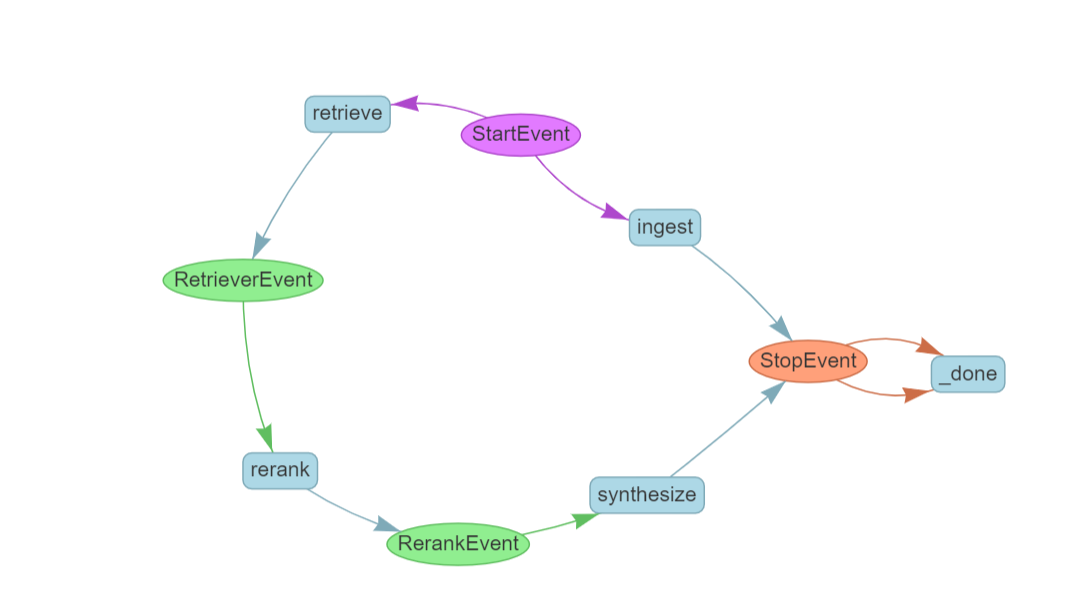

## Recent Execution Workflow

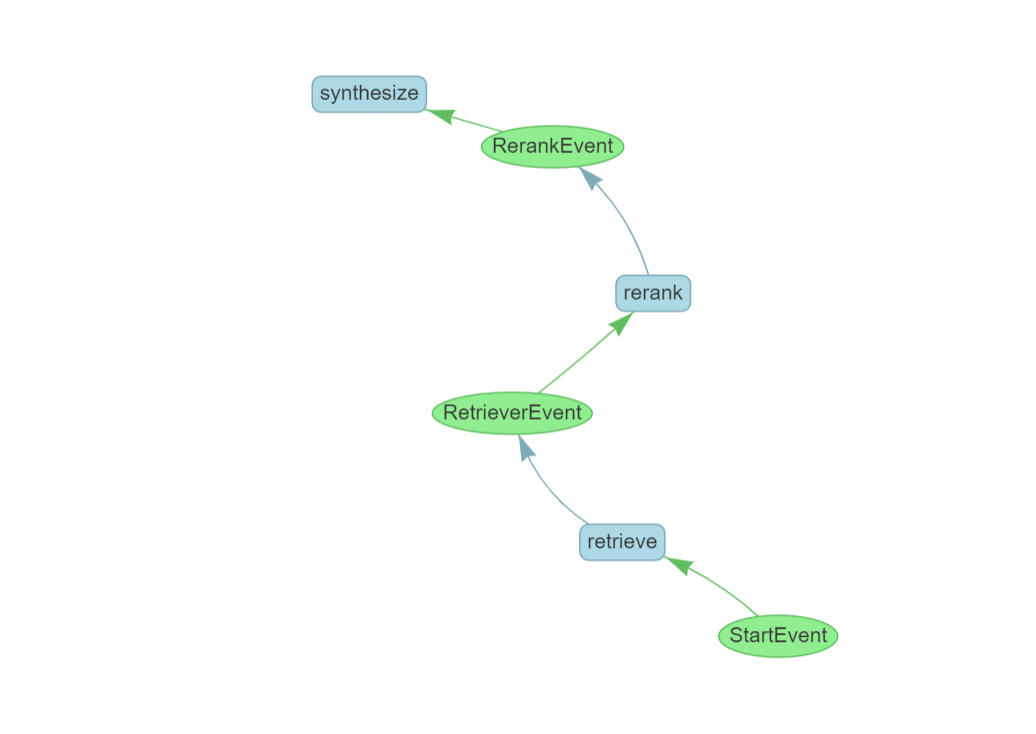

Your observations highlight a few key points regarding compatibility and functionality across different Python versions and environments. Here are some detailed insights and recommendations based on your observations:

1. Python 3.11.0 Compatibility
Observation: The workflow and visualization work correctly with Python 3.11.0.
Recommendation: Python 3.11.0 supports the | operator for type annotations, which simplifies type hinting. If possible, use Python 3.11.0 or later for development to leverage these features and avoid compatibility issues.
2. Python 3.9.12 Compatibility
Observation: The | operator does not work in Python 3.9.12, and you had to modify num_of_events in utils.py.
Recommendation:
Type Hinting: Use Union from the typing module instead of the | operator for type annotations in Python 3.9.12.
Validation Fix: Modifying num_of_events directly in utils.py is a workaround but not ideal. Instead, ensure that each step function has exactly one parameter annotated with the Event type to pass the validation.
3. Visualization in Google Colab
Observation: Visualization is not working in Google Colab even with notebook=True.
Recommendation:
Ensure Proper Installation: Make sure all required packages are installed in Colab.
!pip install pyvis llama-index-core llama-index-llms-openai llama-index-embeddings-openai llama-index-readers-file llama-index-utils-workflow
Check HTML Rendering: Use the following approach to render the HTML content in Colab:
from pyvis.network import Network
from IPython.core.display import display, HTML

def draw_all_possible_flows(
    workflow: Workflow,
    filename: str = "workflow_all_flows.html",
    notebook: bool = True,  # Set notebook to True
) -> None:
    """Draws all possible flows of the workflow."""
    net = Network(directed=True, height="750px", width="100%")

    # Add the nodes + edge for stop events
    net.add_node(
        StopEvent.__name__,
        label=StopEvent.__name__,
        color="#FFA07A",
        shape="ellipse",
    )
    net.add_node("_done", label="_done", color="#ADD8E6", shape="box")
    net.add_edge(StopEvent.__name__, "_done")

    # Add nodes from all steps
    steps = get_steps_from_class(workflow)
    if not steps:
        # If no steps are defined in the class, try to get them from the instance
        steps = get_steps_from_instance(workflow)

    step_config: Optional[StepConfig] = None
    for step_name, step_func in steps.items():
        step_config = getattr(step_func, "__step_config", None)
        if step_config is None:
            continue

        net.add_node(
            step_name, label=step_name, color="#ADD8E6", shape="box"
        )  # Light blue for steps

        for event_type in step_config.accepted_events:
            net.add_node(
                event_type.__name__,
                label=event_type.__name__,
                color="#90EE90" if event_type != StartEvent else "#E27AFF",
                shape="ellipse",
            )  # Light green for events

    # Add edges from all steps
    for step_name, step_func in steps.items():
        step_config = getattr(step_func, "__step_config", None)

        if step_config is None:
            continue

        for return_type in step_config.return_types:
            if return_type != type(None):
                net.add_edge(step_name, return_type.__name__)

        for event_type in step_config.accepted_events:
            net.add_edge(event_type.__name__, step_name)

    if notebook:
        net.show(filename, notebook=True)
        with open(filename, "r") as file:
            display(HTML(file.read()))
    else:
        net.show(filename)

# Example usage in Google Colab
draw_all_possible_flows(
    RAGWorkflow, filename="multi_step_workflow.html", notebook=True
)
Summary
Python 3.11.0: Works well with the | operator and the workflow visualization.
Python 3.9.12: Use Union for type annotations and ensure proper event parameter annotations to avoid modifying utils.py.
Google Colab: Ensure all dependencies are installed and use the provided method to render HTML content.
By following these recommendations, you should be able to achieve consistent functionality across different environments and Python version